In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Loading the dataset
file_path = '../data/feature_engineered_data.csv'
df = pd.read_csv(file_path, index_col = 0)

In [33]:
df

,PRT_ID,AREA,INT_SQFT,DIST_MAINROAD,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,UTILITY_AVAIL,MZZONE,SALES_PRICE,PROPERTY_AGE,BUILDTYPE_commercial,BUILDTYPE_house,BUILDTYPE_others
index,,,,,,,,,,,,,,,
2006-09-05,P09588,5.0,1626.0,37.0,4.0,2.0,1.0,1966-09-15,1.0,2.0,9092600.0,39.972621,0.0,0.0,1.0
2006-09-06,P09585,5.0,1857.0,14.0,5.0,3.0,1.0,1998-09-08,3.0,5.0,16185010.0,7.994524,1.0,0.0,0.0
2006-09-07,P09570,5.0,1930.0,140.0,5.0,5.0,0.0,1962-10-09,1.0,6.0,11853530.0,43.912389,0.0,0.0,1.0
2006-09-08,P09581,5.0,1986.0,101.0,5.0,1.0,0.0,1952-09-21,4.0,6.0,10360480.0,53.963039,0.0,0.0,1.0
2006-09-09,P09580,5.0,1559.0,107.0,4.0,5.0,1.0,1958-09-21,4.0,2.0,12999460.0,47.967146,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-13,P00009,3.0,794.0,160.0,2.0,2.0,0.0,1977-02-22,4.0,4.0,6762300.0,37.973990,0.0,1.0,0.0
2015-02-14,P00005,3.0,704.0,52.0,2.0,1.0,0.0,1976-02-26,4.0,4.0,6248450.0,38.967830,0.0,1.0,0.0
2015-02-15,P00004,6.0,1973.0,81.0,5.0,4.0,1.0,1993-02-22,1.0,6.0,14565090.0,21.979466,0.0,1.0,0.0


In [34]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

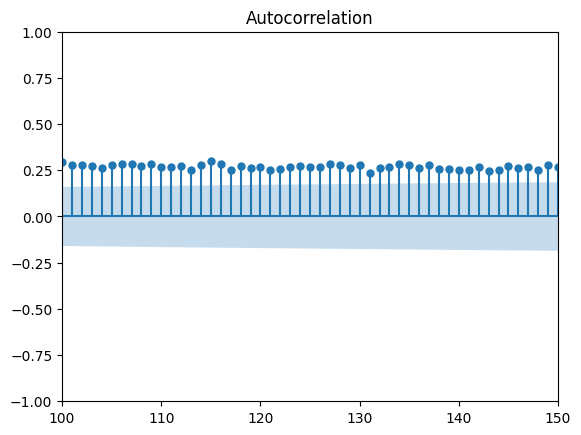

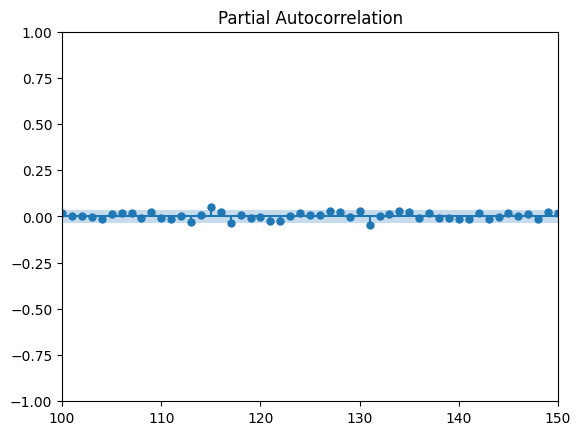

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF zoomed in on lags around 90, 120, and 240
plot_acf(np.log(df['SALES_PRICE']), lags=300)  # Adjust lags to a higher number to see seasonal lags
plt.xlim([100, 150])  # Focus on the lags of interest (e.g., 90, 120, 240)
plt.show()

# Plot PACF zoomed in on lags around 90, 120, and 240
plot_pacf(np.log(df['SALES_PRICE']), lags=300)  # Adjust lags similarly for PACF
plt.xlim([100, 150])
plt.show()

In [36]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the log-transformed total_price series
adf_result = adfuller(df['SALES_PRICE'])

# Extract the test statistic and p-value
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {adf_p_value}')

if adf_p_value < 0.05:
    print("The series is stationary (d=0)")
else:
    print("The series is not stationary, consider differencing (d=1)")


ADF Statistic: -3.152615704749252
p-value: 0.022896589016386092
The series is stationary (d=0)


In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['SALES_PRICE'], model='additive', period=120)

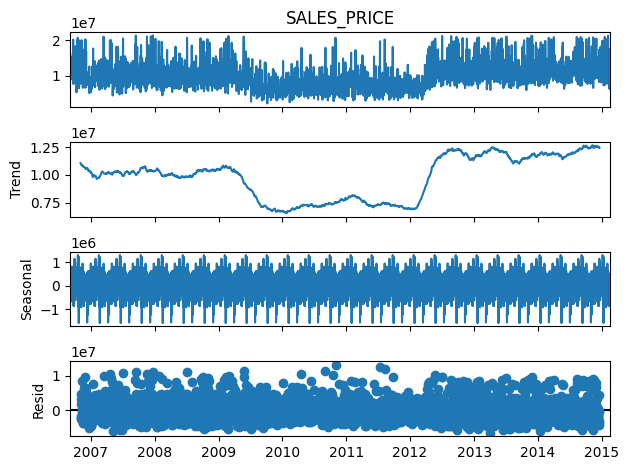

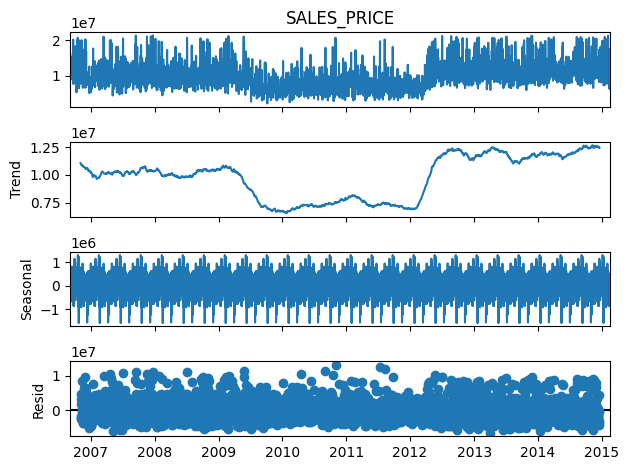

In [38]:
decomposition.plot()

In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from sklearn.model_selection import TimeSeriesSplit

# Transforming sales_price using Box-Cox
df['sales_price_transformed'], lambda_ = boxcox(df['SALES_PRICE'])

# Log transform of sales price (alternative to Box-Cox if preferred)
# df['log_sales_price'] = np.log(df['sales_price'])

# Selecting the transformed variable
y = df['sales_price_transformed']

# Exclude AreaRank_INT_SQFT from the predictors
X = df[['INT_SQFT', 'N_ROOM', 'AREA', 'SALE_COND', 
                 'PARK_FACIL', 'UTILITY_AVAIL', 'MZZONE', 
                 'BUILDTYPE_commercial', 'BUILDTYPE_house', 'PROPERTY_AGE', 'DIST_MAINROAD']]

# Split the data into training and testing sets (last 2 months for testing)
cutoff_date = df.index.max() - pd.DateOffset(months=2)
train = df[df.index <= cutoff_date]
test = df[df.index > cutoff_date]

y_train = train['sales_price_transformed']
X_train = train[X.columns]
y_test = test['sales_price_transformed']
X_test = test[X.columns]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    model = SARIMAX(y_train_fold, exog=X_train_fold, order=(1,0,1), seasonal_order=(0,0,0,0))
    result = model.fit()
    print(result.summary())

# Fitting the final model on the entire training set
final_model = SARIMAX(y_train, exog=X_train, order=(1,0,1), seasonal_order=(0,0,0,0))
final_results = final_model.fit()
print(final_results.summary())

# Optionally, forecast on the test set
forecast = final_results.get_forecast(steps=len(X_test), exog=X_test)
forecast.summary_frame()


                                  SARIMAX Results                                  
Dep. Variable:     sales_price_transformed   No. Observations:                 1010
Model:                    SARIMAX(1, 0, 1)   Log Likelihood               -4168.784
Date:                     Wed, 02 Oct 2024   AIC                           8365.569
Time:                             23:05:48   BIC                           8434.417
Sample:                         09-05-2006   HQIC                          8391.723
                              - 06-10-2009                                         
Covariance Type:                       opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
INT_SQFT                -0.0297      0.004     -7.024      0.000      -0.038      -0.021
N_ROOM                  22.2661      1.612     13.810      0.

sales_price_transformed,mean,mean_se,mean_ci_lower,mean_ci_upper
2014-12-18,109.596060,10.069425,89.860351,129.331770
2014-12-19,114.414332,10.182601,94.456801,134.371862
2014-12-20,123.269229,10.294061,103.093240,143.445218
2014-12-21,103.846302,10.403863,83.455105,124.237500
2014-12-22,121.638438,10.512061,101.035178,142.241699
...,...,...,...,...
2015-02-13,87.899542,14.754218,58.981806,116.817279
2015-02-14,90.969419,14.815080,61.932396,120.006441
2015-02-15,116.117169,14.875436,86.961852,145.272487
2015-02-16,94.590837,14.935294,65.318199,123.863474


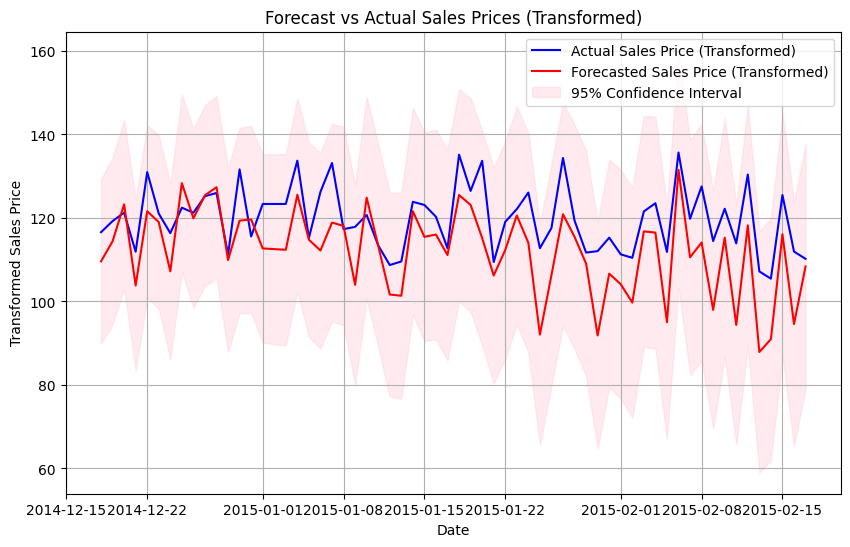

In [40]:
import matplotlib.pyplot as plt

# Forecast on the test set
forecast = final_results.get_forecast(steps=len(X_test), exog=X_test)
forecast_df = forecast.summary_frame()

# Plotting the forecast vs actual sales prices
plt.figure(figsize=(10, 6))

# Plot the actual test data
plt.plot(y_test.index, y_test, label='Actual Sales Price (Transformed)', color='blue')

# Plot the forecasted sales price (transformed)
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecasted Sales Price (Transformed)', color='red')

# Add confidence intervals
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

# Labels and title
plt.title('Forecast vs Actual Sales Prices (Transformed)')
plt.xlabel('Date')
plt.ylabel('Transformed Sales Price')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
import pickle

# Save the final SARIMAX model to a file
with open('final_sarimax_model.pkl', 'wb') as f:
    pickle.dump(final_results, f)

print("Model saved successfully!")

Model saved successfully!
